# SPAM Filter with Natural Language Processing !

## Section I Data Analysis

### Step 1:

##### import all modules

In [1]:
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import pandas as pd
import string
import seaborn as sns

import matplotlib.pyplot as plt
from wordcloud import WordCloud

#### Read in the dataset

In [2]:
df = pd.read_csv("spam_ham.txt", sep="\t", names=["label","message"])
df.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


##### This gives us a glimpse of thhe description of the data

In [3]:
df.describe()

,label,message
count,5572,5572
unique,2,5158
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


##### Using this function we get a better understanding of the dataset

In [5]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    642  Please call our customer service representativ...    4

This shows us how many Spam vd Normal Messages we have in the Dataset we have about 747 apam messages and 4825 messages which are not spam and 4500 is uniqe messages from there

# Step 2:

#### Further feature extraction 

In [6]:
df["Length"] = df["message"].apply(len)
df.head()

,label,message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


This added feature will help the model in terms of prediction. It will now also use message length as a predictor.

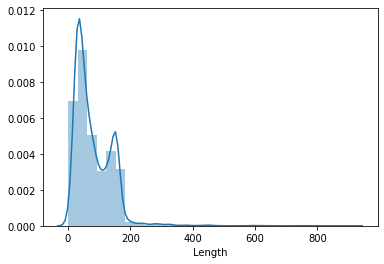

In [7]:
sns.distplot(df["Length"], bins=30)

The figure above shows us the distribution of message length across the dataset.

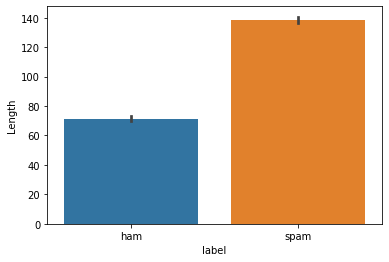

In [8]:
sns.barplot(x='label', y='Length', data=df)

The figure above shows that the spam category has a substantially larger message length.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1265d89e8>,
      dtype=object)

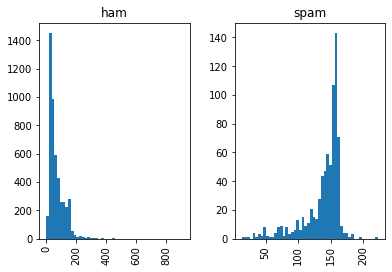

In [9]:
df.hist(column='Length',by='label', bins=50)

The histograms above illustraate the previous point even further.

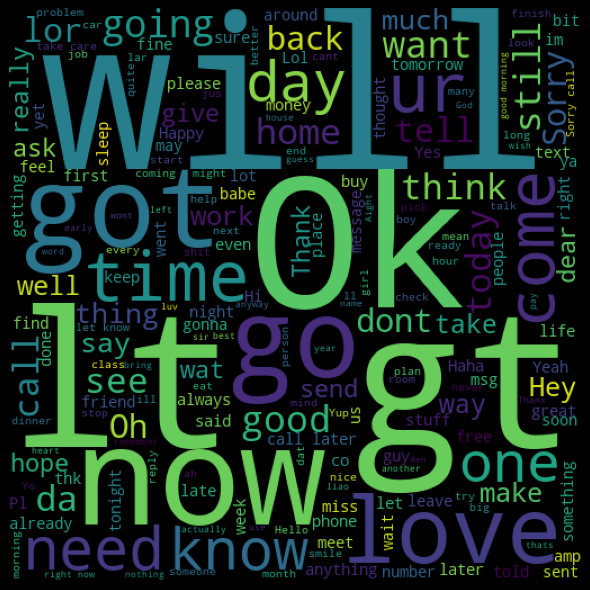

In [10]:
spam_words = ' '.join(list(df[df['label'] == 'ham']['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

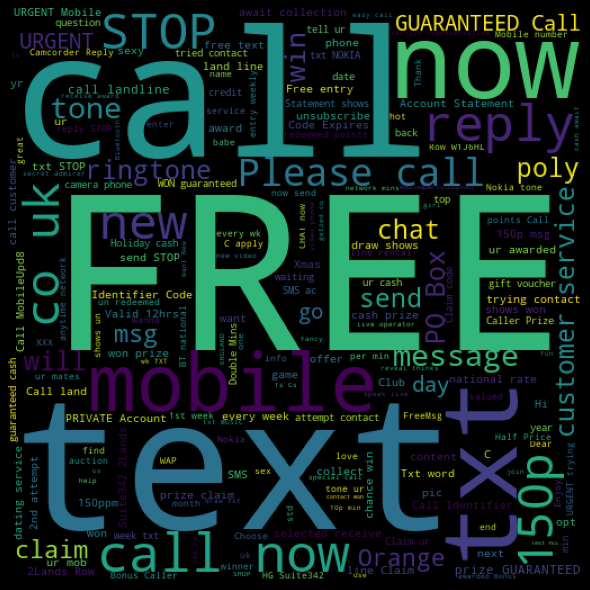

In [11]:
spam_words = ' '.join(list(df[df['label'] == 'spam']['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Spam emails tend to have quite a large volume of messages including 'FREE', 'CALL', 'TEXT'. When compared to to ham  emails which include 'will', 'It', and 'love'. There are clear differences between both which is a positive indicator that our model mayy be aable topick up on this.

### A small library to pre-process data

In [12]:
class PreProcessText(object):
    def __init__(self):
        pass
    
    def __remove_punctuation(self, text):
        """
        Takes a String 
        return : Return a String 
        """
        message = []
        for x in text:
            if x in string.punctuation:
                pass
            else:
                message.append(x)
        message = ''.join(message)
        
        return message
    
    def __remove_stopwords(self, text):
        """
        Takes a String
        return List
        """
        words= []
        for x in text.split():

            if x.lower() in stopwords.words('english'):
                pass
            else:
                words.append(x)
        return words
    
    
    def token_words(self,text=''):
        """
        Takes String
        Return Token also called  list of words that is used to 
        Train the Model 
        """
        message = self.__remove_punctuation(text)
        words = self.__remove_stopwords(message)
        return words

###### Testing the library

In [13]:
mess = 'Sample message! Notice: it has punctuation.'
obj = PreProcessText()
words = obj.token_words(mess)
print(words)

['Sample', 'message', 'Notice', 'punctuation']


#### We have converted our string into token for our model

In [14]:
df["message"].head(4).apply(obj.token_words)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
Name: message, dtype: object

#### Vectorisaation

In [15]:
bow_transformer = CountVectorizer(analyzer=obj.token_words).fit(df["message"])

In [16]:
messages_bow = bow_transformer.transform(df["message"])

In [17]:
print("Shape of sparese matrix {}".format(messages_bow.shape))

Shape of sparese matrix (5572, 11425)


### Formula to check Sparsity

In [18]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


#### Converting wordd count to TFIDF

In [19]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [20]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

### Train the model

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
model = MultinomialNB().fit(messages_tfidf,df["label"])

### Predicition

In [23]:
all_predictions = model.predict(messages_tfidf)
pred = pd.DataFrame(data=all_predictions)

pred.head(6)

,0
0,ham
1,ham
2,spam
3,ham
4,ham
5,ham


### True Value

In [24]:
df["label"].head(6)

0     ham
1     ham
2    spam
3     ham
4     ham
5    spam
Name: label, dtype: object